In [2]:
import glob 
import sys 
sys.path.append('..')
from print_results import get_stats
import matplotlib.pyplot as plt 
import numpy as np 

In [3]:
to_search = {
    'lanl': {
        'static': '../results/rw/lanl14argus/snapshot-ft_results_snapshot_bert_static*.txt', 
        'temporal': '../results/trw/lanl14argus/snapshot-ft_results_snapshot_bert*.txt'
    }, 
    'unsw': {
        'static': '../results/rw/unsw/snapshot-ft_results_snapshot_bert_static*.txt', 
        'temporal': '../results/trw/unsw/snapshot-ft_results_snapshot_bert*.txt'
    },
    'optc': { # Stupidly used a different naming convention for CLS finetuning
        'static': '../results/ft/optc/static_results_snapshot_bert*.txt', 
        'temporal': '../results/ft/optc/rwft_results_snapshot_bert*.txt', 
    },
    'optc-gfm': { # Can't really define how well an untrained cls model does, but can compare to 
                  # non-finetuned LP models did 
        'static': '../results/rw/optc/snapshot-ft_results_snapshot_bert_static*.txt', 
        'temporal': '../results/trw/optc/snapshot-ft_results_snapshot_bert*.txt'

    }
}

best = dict() 
results = dict() 
for dataset,temporal_map in to_search.items(): 
    results[dataset] = dict()
    
    for isTemporal,search in temporal_map.items(): 
        nft,auc,ap = get_stats(glob.glob(search))
        results[dataset][isTemporal] = {
            'finetuned': auc[['tiny_auc', 'tiny_ap']].sort_index(inplace=False),
            'base': nft[['tiny_auc', 'tiny_ap']].sort_index(inplace=False)
        }

        best_wl = auc.idxmax(skipna=True)['tiny_ap']
        
        best[f'{dataset}-{isTemporal[0].upper()}'] = (
            auc.loc[best_wl, 'tiny_auc'], 
            auc.loc[best_wl, 'tiny_ap']
        )

import json 
print(json.dumps(best, indent=1))

{
 "lanl-S": [
  0.9971868639311527,
  0.3585815464735521
 ],
 "lanl-T": [
  0.9950435802900425,
  0.22943093852193036
 ],
 "unsw-S": [
  0.9938543139183659,
  0.9918617379042277
 ],
 "unsw-T": [
  0.9951782048399277,
  0.9937561565223243
 ],
 "optc-S": [
  0.9877201975605931,
  0.9025106612763546
 ],
 "optc-T": [
  0.9810463016365217,
  0.8835115608050729
 ],
 "optc-gfm-S": [
  0.8789479182309584,
  0.4470506748976601
 ],
 "optc-gfm-T": [
  0.9180279475503592,
  0.4122754439459259
 ]
}


/tmp/ipykernel_3485907/1314134288.py:34: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_wl = auc.idxmax(skipna=True)['tiny_ap']
/tmp/ipykernel_3485907/1314134288.py:34: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_wl = auc.idxmax(skipna=True)['tiny_ap']
/tmp/ipykernel_3485907/1314134288.py:34: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_wl = auc.idxmax(skipna=True)['tiny_ap']
/tmp/ipykernel_3485907/1314134288.py:34: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_wl = auc.idxmax(skipna=True)['tiny_ap']
/tmp/ipykernel_3

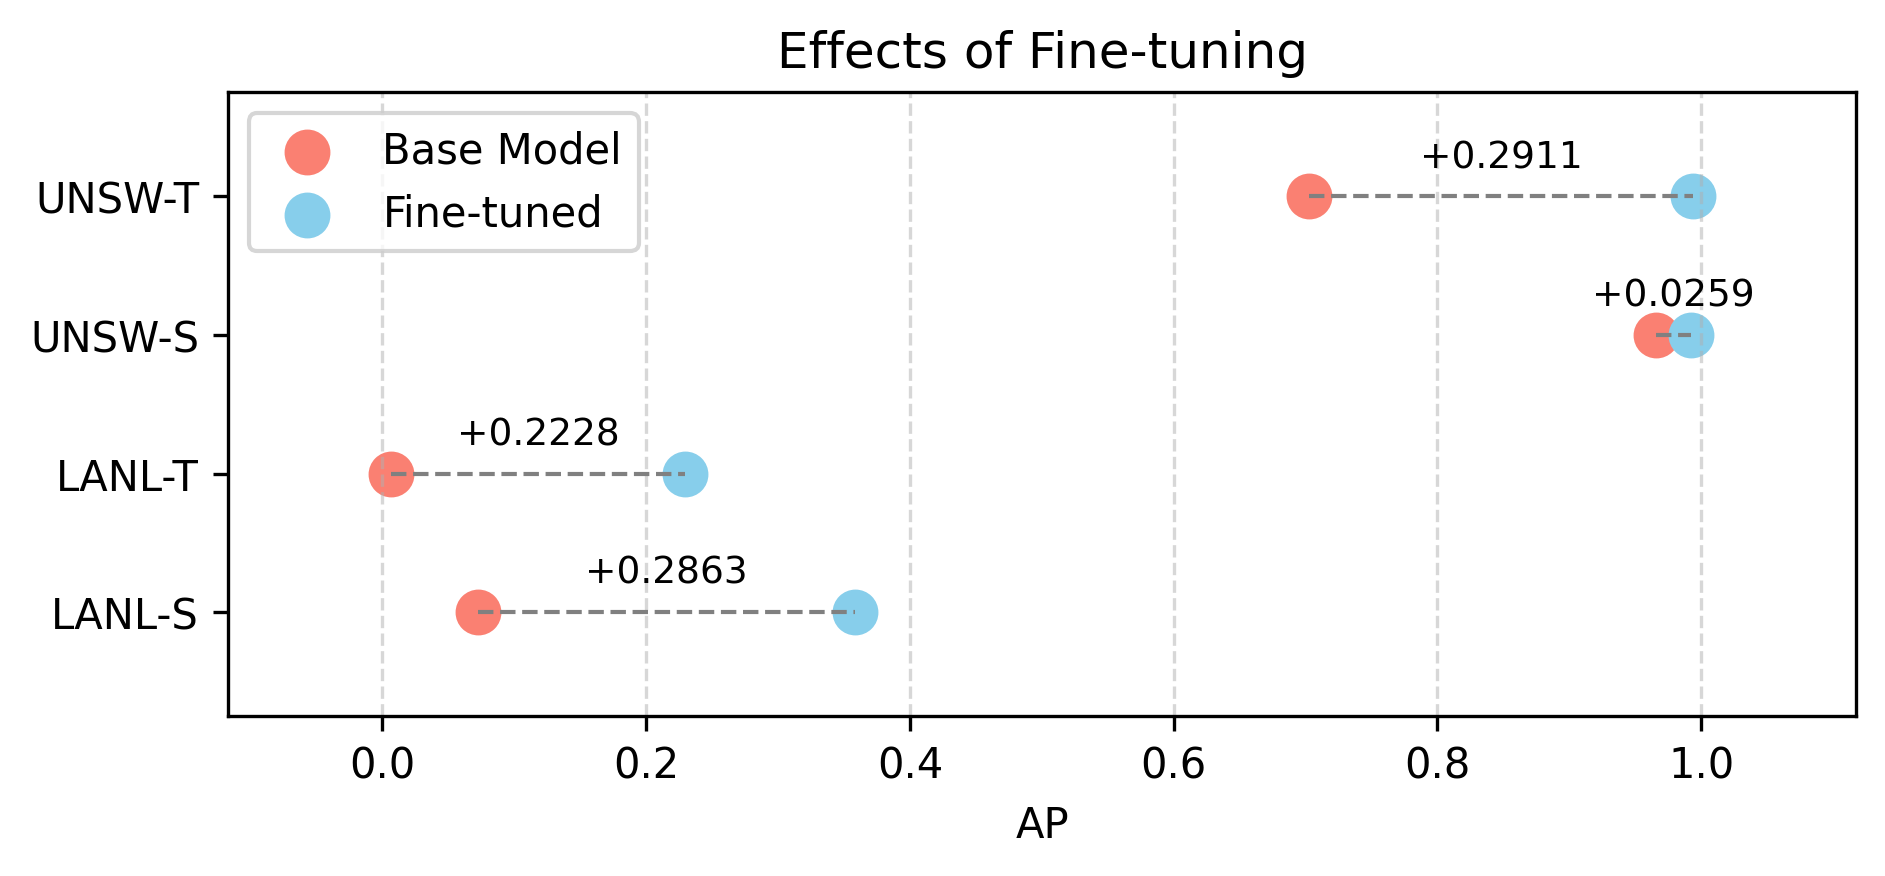

In [4]:
before_after = []
labels = []

dataset = 'lanl'
temp = 'static'

label_map = {
    'optc-gfm': 'OpTC',
    'optc': 'OpTC',
    'unsw': 'UNSW', 
    'lanl': 'LANL', 
    'static': 'S',
    'temporal': 'T'
}

for dataset in ['lanl', 'unsw']: 
    for temp in ['static', 'temporal']:
        dfs = results[dataset][temp]
        best_wl = dfs['finetuned'].idxmax()['tiny_ap']
        ft_ap = dfs['finetuned'].loc[best_wl, 'tiny_ap']

        #if dataset != 'optc': 
        #    gfm_ap = dfs['base'].loc[best_wl, 'tiny_ap']
        #else: 
        #    gfm_ap = results['optc-gfm'][temp]['base'].loc[best_wl, 'tiny_ap']
        gfm_ap = dfs['base'].loc[best_wl, 'tiny_ap']
        
        before_after.append([gfm_ap, ft_ap])
        labels.append(f'{label_map[dataset]}-{label_map[temp]}')

data = np.array(before_after)
n = data.shape[0]
before = data[:, 0]
after = data[:, 1]

colors = ['navy', 'navy', 'darkkhaki', 'darkkhaki', 'dimgray', 'dimgray']

plt.figure(figsize=(7, 2.7), dpi=300)

# Plot "before" and "after" as dots
y = np.arange(n)

# Connect the dots with horizontal lines and label the differences
for i in range(n):
    plt.plot([before[i], after[i]], [y[i], y[i]], color='gray', linestyle='--', linewidth=1)
    diff = after[i] - before[i]
    mid_x = (before[i] + after[i]) / 2
    plt.text(mid_x, y[i]+0.15, f'{"+" if diff>0 else "-"}{diff:0.4f}', ha='center', va='bottom', fontsize=9, color='black')

plt.scatter(before, y, color='salmon', s=100, label='Base Model')
plt.scatter(after, y, color='skyblue', s=100, label='Fine-tuned')

# Annotate each point with its value
#for i in range(n):
#    plt.text(before[i], y[i], f'{before[i]:0.2f}', ha='left', va='center', fontsize=9)
#    plt.text(after[i], y[i], f'{after[i]:0.2f}', ha='left', va='center', fontsize=9)

# Formatting
plt.yticks(y, labels)
plt.xlabel("AP")
plt.title("Effects of Fine-tuning")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.margins(x=0.125, y=0.25)
plt.show()

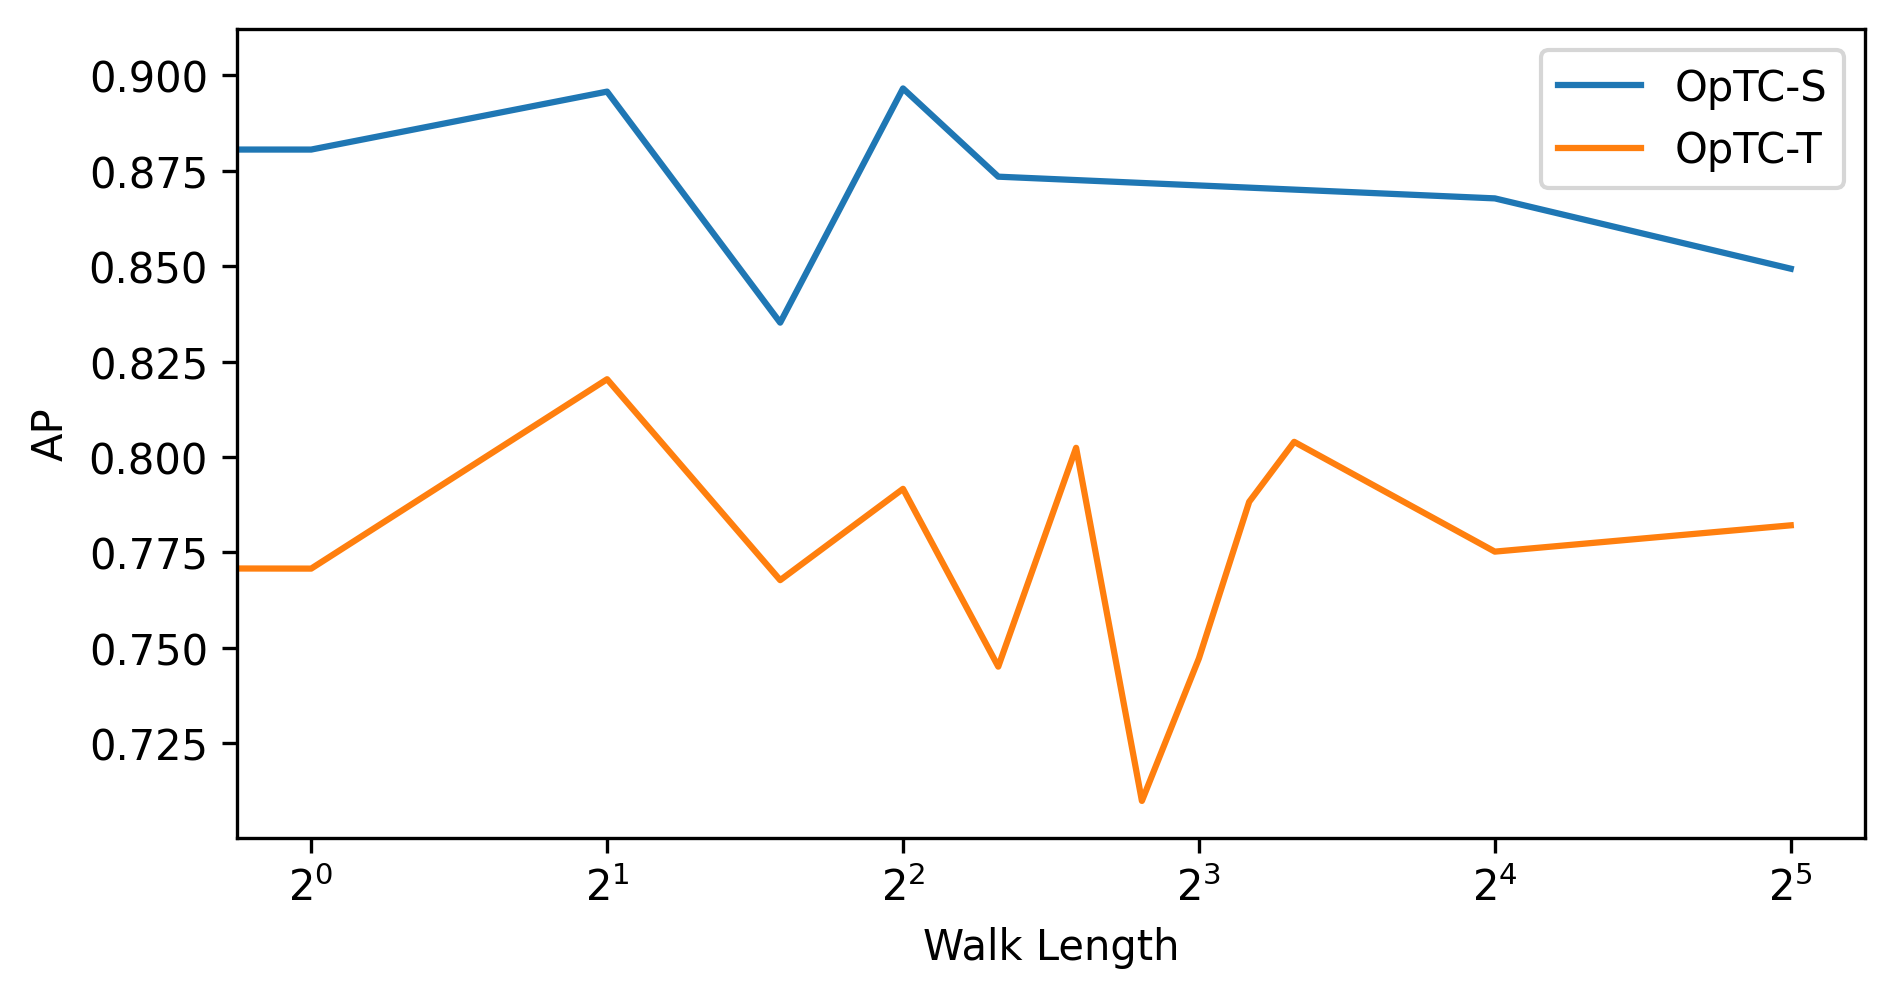

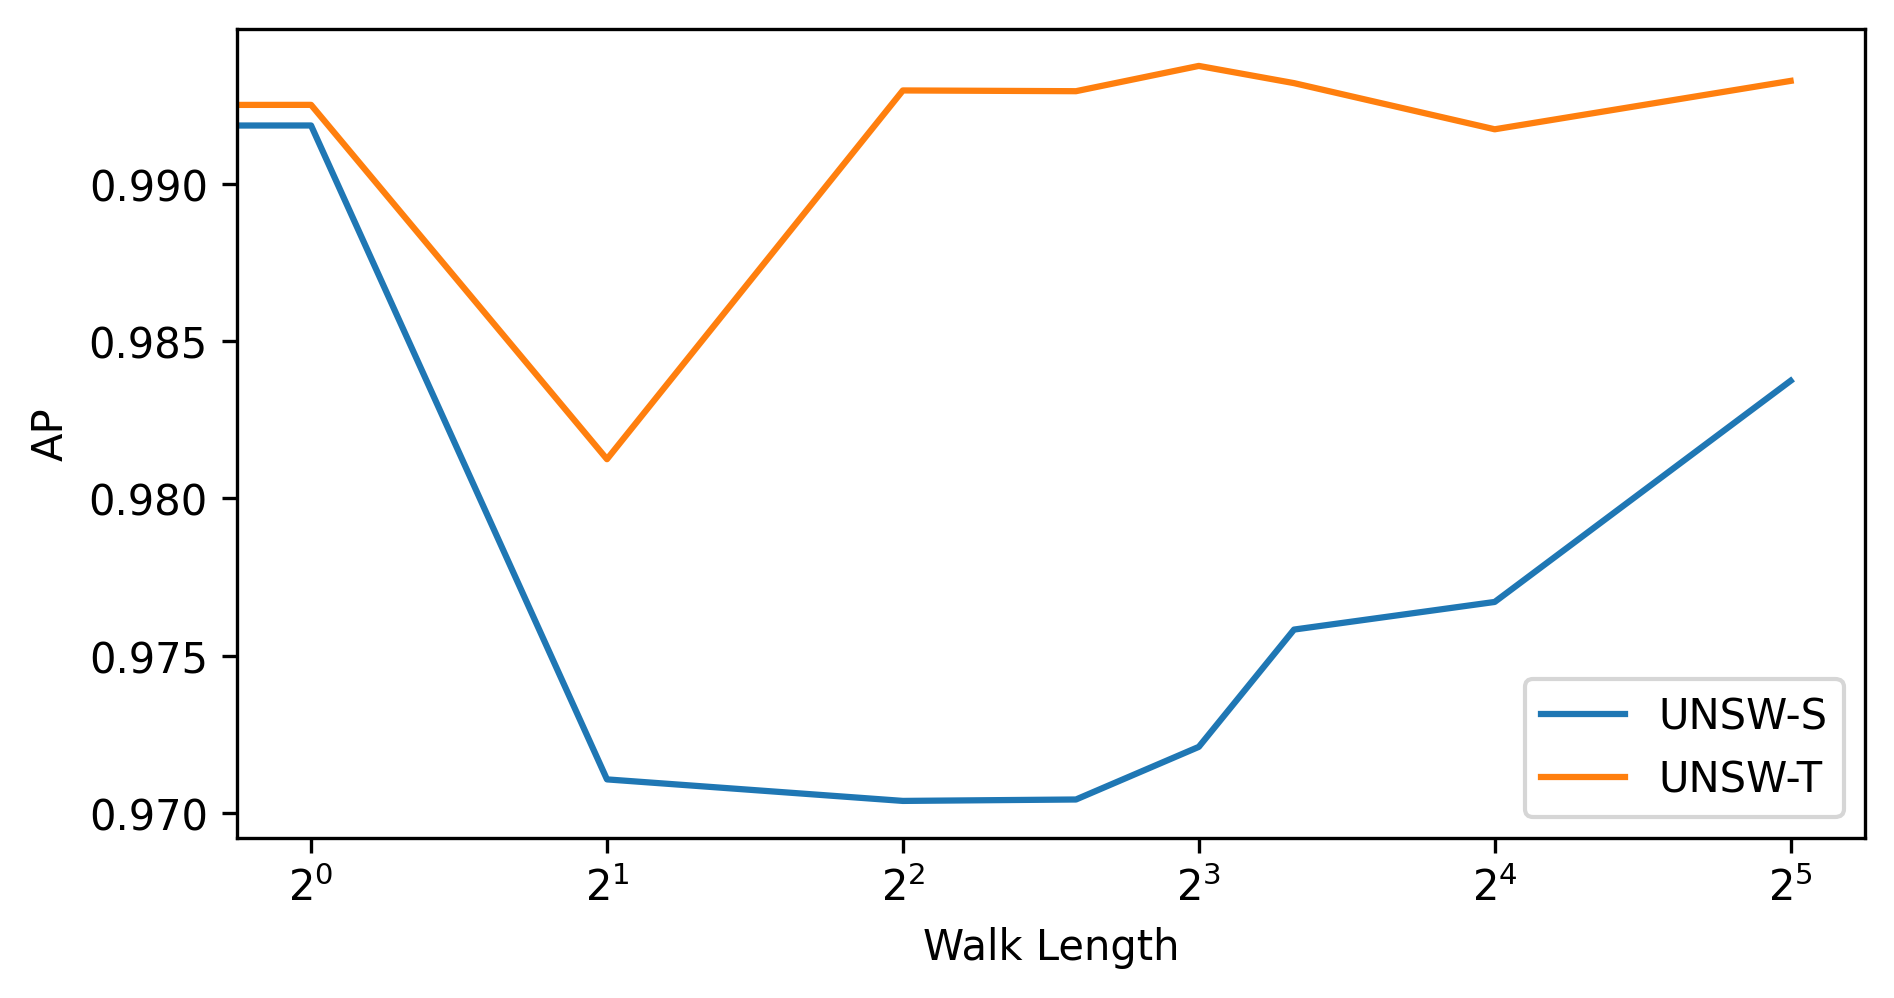

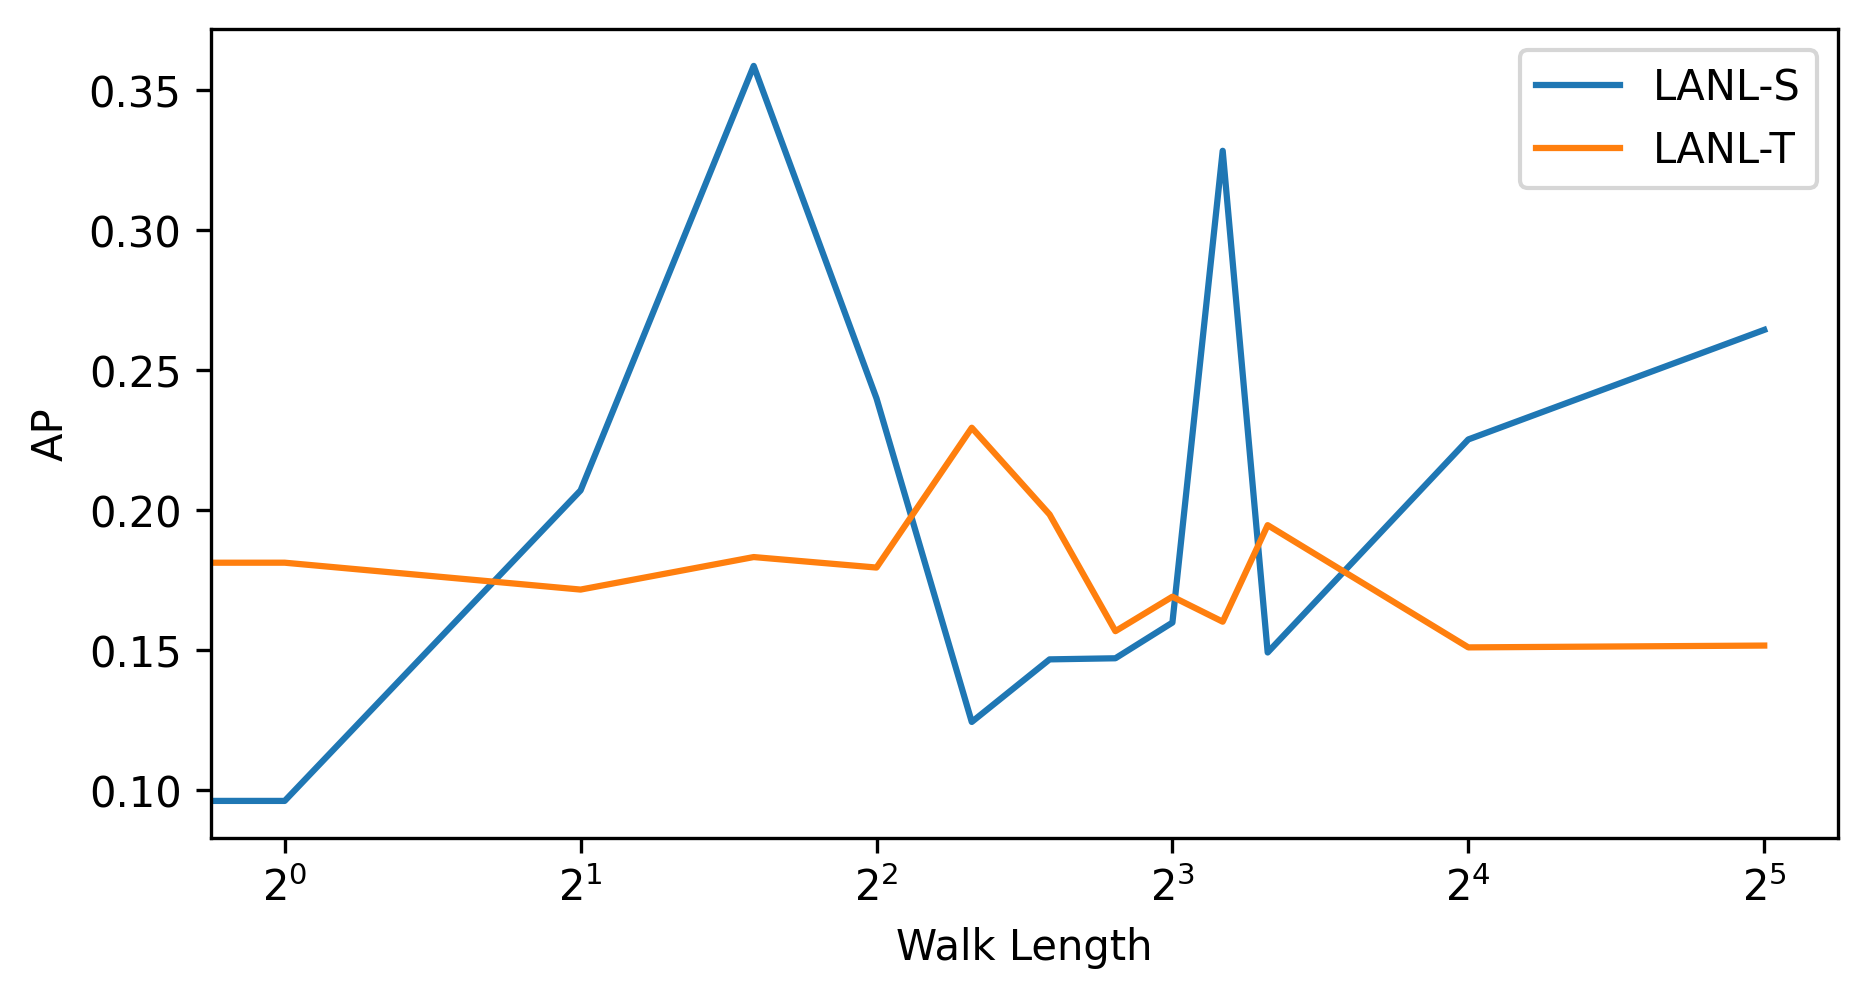

In [5]:
walk_to_ap = []
labels = []

for dataset in ['optc', 'unsw', 'lanl']: 
    for temp in ['static', 'temporal']: 
        df = results[dataset][temp]['finetuned']
        wta = df.reset_index()[['index', 'tiny_ap', 'tiny_auc']].to_numpy()
        wta = wta[wta[:,1] != 0]
        
        walk_to_ap.append(wta)
        labels.append(f'{label_map[dataset]}-{label_map[temp]}')

    plt.figure(figsize=(7, 3.5), dpi=300)

    for i in range(len(walk_to_ap)): 
        wta = walk_to_ap[i]
        label = labels[i]

        plt.plot(wta[:,0], wta[:,1], label=label, color=f'C{i}')
        #plt.plot(wta[:,0], wta[:,2], label=label+" AUC", linestyle='--', color=f'C{i}')

    walk_to_ap = []
    labels = []

    plt.legend() 
    plt.xscale('log', base=2)
    plt.ylabel("AP")
    plt.xlabel('Walk Length')
    plt.show()

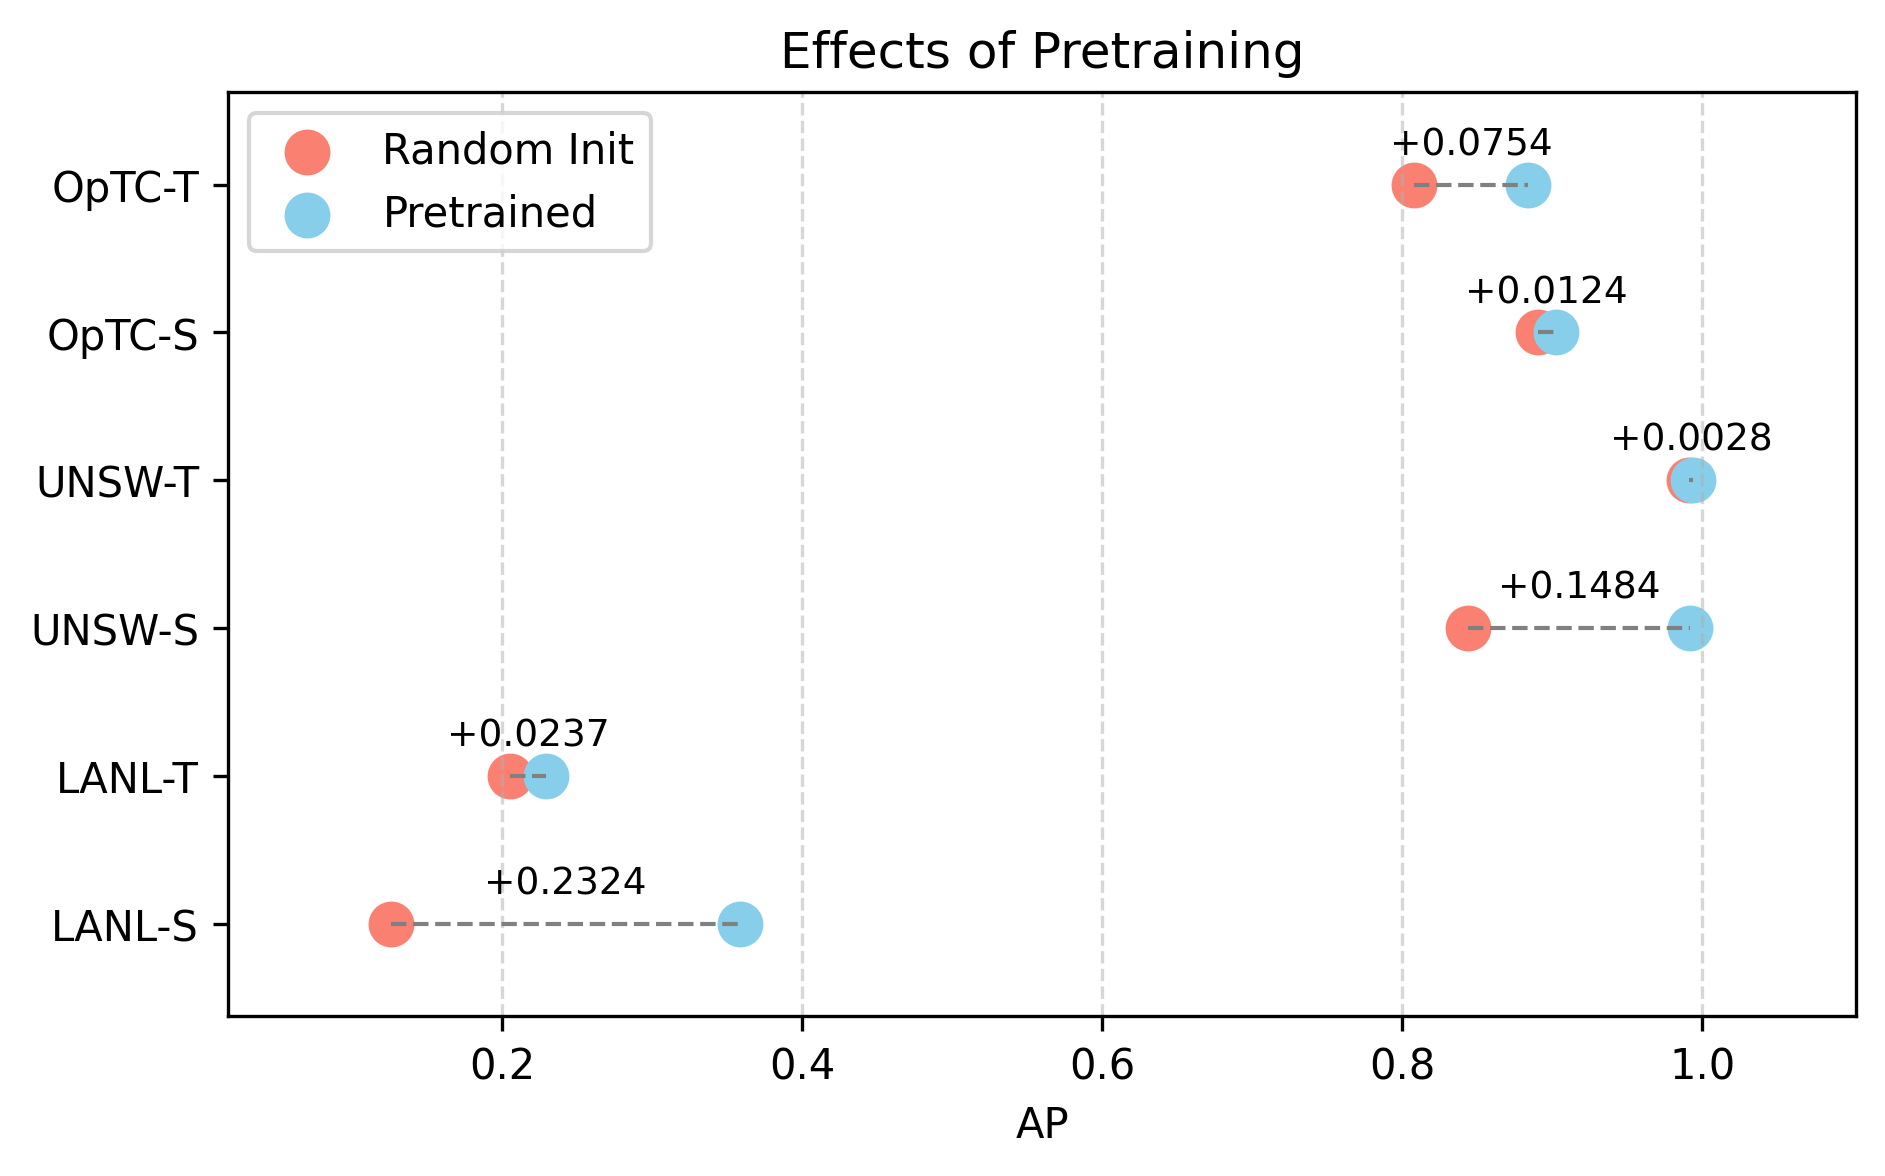

In [6]:
dmap = dict() 

from_scratch_files = glob.glob('../results/**/**/*_rand_init_*')
for f in from_scratch_files:
    nft,auc,ap = get_stats([f])
    auc = auc[['tiny_ap', 'tiny_auc']]
    best_rnd = auc.loc[auc.idxmax(skipna=True)['tiny_ap']]
    auc,ap = best_rnd['tiny_auc'], best_rnd['tiny_ap']
    
    dataset = f.split('/')[3]

    if dataset != 'optc': 
        t = 'S' if f.split('/')[2] == 'rw' else 'T'
    else: 
        t = 'S' if f.split('/')[-1].startswith('static') else 'T'

    dmap[dataset[:4]+'-'+t] = ap 

bars = []
labels = []
for dataset in ['lanl', 'unsw', 'optc']:
    for t in ['S', 'T']: 
        k = f'{dataset}-{t}'
    
        try: 
            rnd = dmap[k]
        except: 
            rnd = 0 
        
        ft = best[k][1]
        bars.append([rnd,ft])

        # Hacky way to make it display as OpTC
        labels.append(k.upper().replace('P', 'p'))


data = np.array(bars)
n = data.shape[0]
before = data[:, 0]
after = data[:, 1]

colors = ['navy', 'navy', 'darkkhaki', 'darkkhaki', 'dimgray', 'dimgray']

plt.figure(figsize=(7, 4), dpi=300)

# Plot "before" and "after" as dots
y = np.arange(n)

# Connect the dots with horizontal lines and label the differences
for i in range(n):
    plt.plot([before[i], after[i]], [y[i], y[i]], color='gray', linestyle='--', linewidth=1)
    diff = after[i] - before[i]
    mid_x = (before[i] + after[i]) / 2
    plt.text(mid_x, y[i]+0.15, f'+{diff:0.4f}', ha='center', va='bottom', fontsize=9, color='black')

plt.scatter(before, y, color='salmon', s=100, label='Random Init')
plt.scatter(after, y, color='skyblue', s=100, label='Pretrained')

# Annotate each point with its value
#for i in range(n):
#    plt.text(before[i], y[i], f'{before[i]:0.2f}', ha='left', va='center', fontsize=9)
#    plt.text(after[i], y[i], f'{after[i]:0.2f}', ha='left', va='center', fontsize=9)

# Formatting
plt.yticks(y, labels)
plt.xlabel("AP")
plt.title("Effects of Pretraining")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.margins(x=0.125, y=0.125)
plt.show()

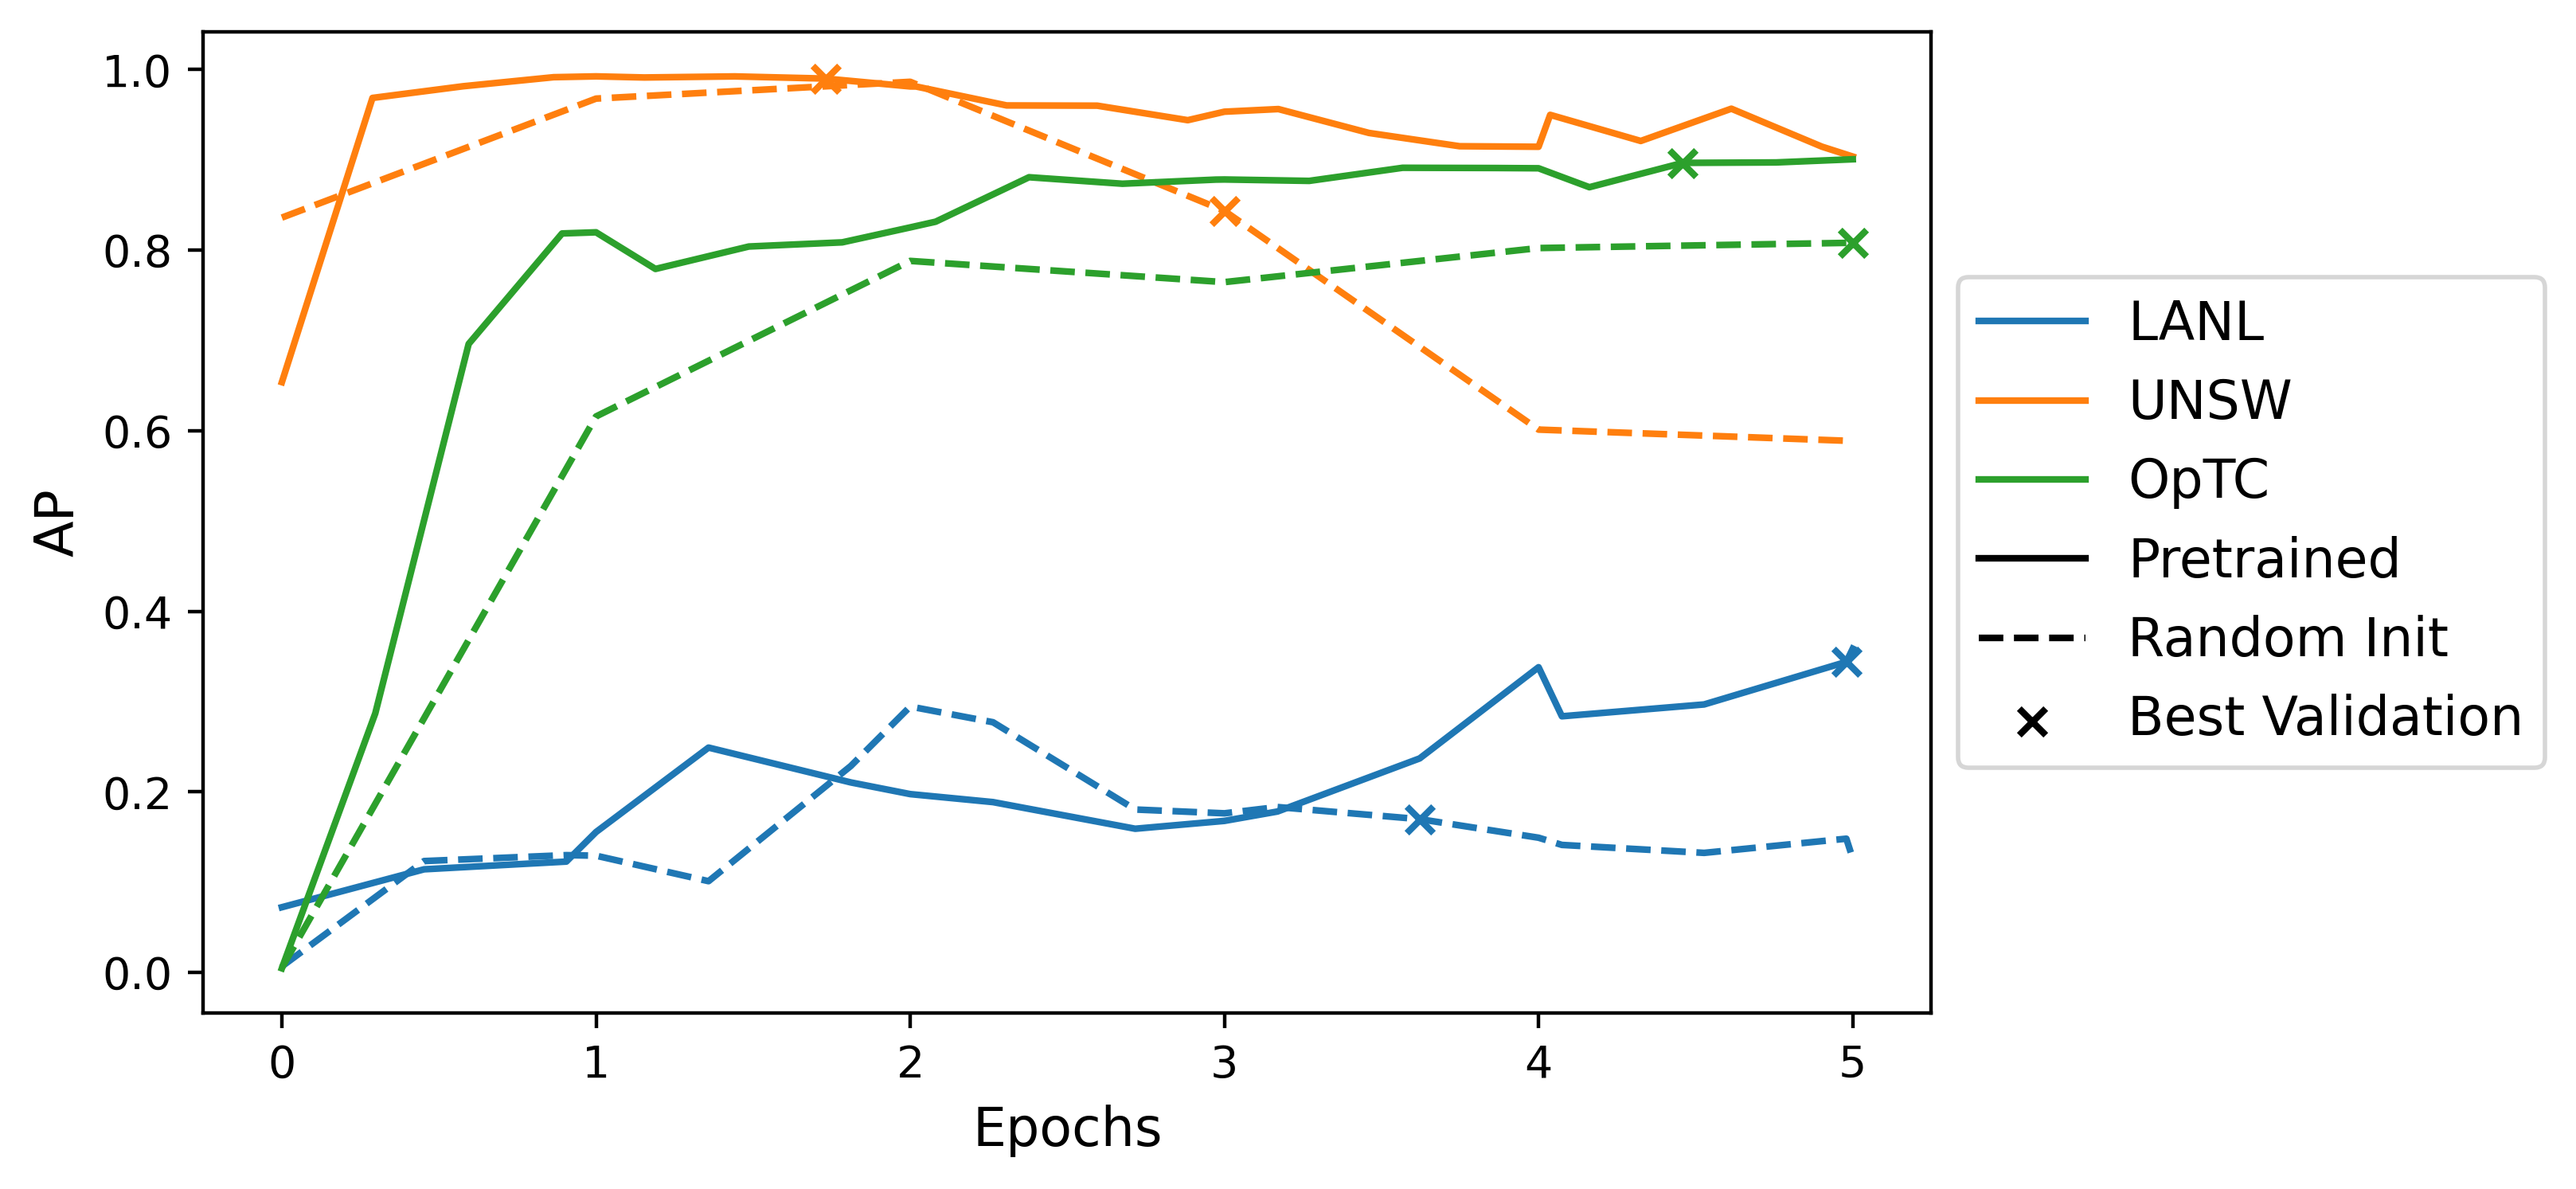

In [9]:
import pandas as pd 

def display(df, df_ri, label, color): 
    df = df[df['epoch'] <= 5].copy()
    df_ri = df_ri[df_ri['epoch'] <= 5].copy()

    df['updates'] /= df['updates'].max() * 0.2
    df_ri['updates'] /= df_ri['updates'].max() * 0.2

    best_val = df.idxmax()['val_auc']
    best_val_ri = df_ri.idxmax()['val_auc']

    plt.plot(df['updates'], df['ap'], label=label, color=color)
    plt.plot(df_ri['updates'], df_ri['ap'], linestyle='--', color=color)

    plt.scatter(df.loc[best_val, 'updates'], df.loc[best_val, 'ap'], marker='x', color=color)
    plt.scatter(df_ri.loc[best_val_ri, 'updates'], df_ri.loc[best_val_ri, 'ap'], marker='x', color=color)

plt.figure(figsize=(7, 4), dpi=400)

df = pd.read_csv('../results/rw/lanl14argus/snapshot-ft_results_snapshot_bert_static_tiny_wl3.txt')
df_ri = pd.read_csv('../results/rw/lanl14argus/snapshot-ft_results_rand_init_snapshot_bert_static_tiny_wl4.txt')
display(df,df_ri, 'LANL', 'C0')

df = pd.read_csv('../results/trw/unsw/snapshot-ft_results_snapshot_bert_tiny_wl2.txt')
df_ri = pd.read_csv('../results/rw/unsw/snapshot-ft_results_rand_init_snapshot_bert_static_tiny_wl8.txt')
display(df,df_ri, 'UNSW', 'C1')


df = pd.read_csv('../results/ft/optc/static_results_snapshot_bert_tiny_wl4.txt')
df_ri = pd.read_csv('../results/ft/optc/rwft_rand_init_results_snapshot_bert_tiny_wl6.txt')
display(df,df_ri, 'OpTC', 'C2')

plt.plot([],[], label='Pretrained', color='black')
plt.plot([],[], label='Random Init', linestyle='--', color='black')
plt.scatter([],[], marker='x', label='Best Validation', color='black')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.ylabel('AP', size=12)
plt.xlabel('Epochs', size=12)
plt.show()